# Setting up the Environment

Make sure to set your runtime to use the GPU.

Runtime -> Change runtime type -> Hardware accelerator -> T4 GPU -> Save

In [ ]:
!pip install transformers
!pip install datasets

In [ ]:
from datasets import Dataset
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, pipeline
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import os
from google.colab import files
import json

os.environ["WANDB_DISABLED"] = "true"

# Importing and Creating Data

Here we upload a kaggle dataset of approximately 4000-5000 amazon dog food reviews. We then append to this dataset a list of 300 ChatGPT generated reviews to have a larger variety in size of reviews. This is because many of the amazon dog food reviews are hundreds of words, and we wanted this model to be good at classifying the sentiment of short reviews too.

In [ ]:
uploaded = files.upload()

Saving sample-dog-food.json to sample-dog-food (1).json


In [ ]:
# Load JSON data
with open('sample-dog-food.json', 'r') as f:
    data_json = json.load(f)

# Extract and label reviews
reviews = data_json["reviews"]
dog_food_reviews1 = []

for review in reviews:
    rating = review["rating"]
    text = review["review_text"]
    if rating in [4, 5]:
        label = 1  # Positive
        dog_food_reviews1.append((text, label))
    elif rating in [1, 2]:
        label = 0  # Negative
        dog_food_reviews1.append((text, label))
    # 3-star reviews are ignored

#ChatGPT Generated Reviews:
dog_food_reviews2 = [
    # Cluster 1: Smell is appealing
    ("This dog food smells amazing—almost like a chicken stew.", 1),
    ("It has a delicious smell that even I find pleasant.", 1),
    ("The aroma is rich and savory—my dog comes running.", 1),
    ("Way better-smelling than other brands I’ve tried.", 1),
    ("It actually smells like real chicken and rice.", 1),
    ("The pleasant aroma fills the whole kitchen.", 1),
    ("I love how fresh and wholesome it smells.", 1),
    ("The smell alone made me confident it was good quality.", 1),
    ("Smells better than some canned human soups!", 1),
    ("Even picky dogs react instantly to the smell.", 1),
    ("The scent is fresh, not fake like some brands.", 1),
    ("Very appetizing smell, my dog gets excited.", 1),
    ("Rich meaty aroma without being overpowering.", 1),
    ("I almost thought it was human food because of the smell.", 1),
    ("Pleasant smell compared to old kibble brands.", 1),
    ("Smells clean, natural, and wholesome.", 1),
    ("My neighbor's dog also goes crazy smelling it.", 1),
    ("Freshness can be smelled right out of the bag.", 1),
    ("It smelled better than my own dinner.", 1),
    ("Scent didn't smell chemical-like like other brands.", 1),

    # Cluster 2: Dogs eagerly eat it
    ("My dog devours it in seconds.", 1),
    ("She licks the bowl clean every single time.", 1),
    ("My picky poodle actually begs for more now.", 1),
    ("Even my older dog with little appetite finishes it.", 1),
    ("My puppy refuses any other food now.", 1),
    ("They love it so much, we had to hide the bag.", 1),
    ("My dogs dance around every feeding time now.", 1),
    ("No more coaxing or tricking them to eat.", 1),
    ("It’s like a treat to them, not just food.", 1),
    ("Absolutely no leftovers—ever!", 1),
    ("My senior dog wolfs it down happily.", 1),
    ("Even my anxious rescue dog eats it with gusto.", 1),
    ("I don’t have to mix it with wet food anymore.", 1),
    ("Both my large and small dogs adore it.", 1),
    ("Every meal feels like a celebration to them.", 1),
    ("Picky eater no more—this food works!", 1),
    ("No sniff-and-walk-away behavior anymore.", 1),
    ("They even sit by the pantry door now.", 1),
    ("Fastest I’ve ever seen them finish a meal.", 1),
    ("She even whines with excitement when I open the bag.", 1),

    # Cluster 3: Coat, digestion, health improvements
    ("My dog's coat is shinier and softer after a month.", 1),
    ("Fewer rashes and much less itching now.", 1),
    ("My senior dog seems more energetic and mobile.", 1),
    ("Stool is firmer and less smelly than before.", 1),
    ("Helped with my bulldog’s constant scratching.", 1),
    ("My Labrador's fur looks glossy and healthy.", 1),
    ("No more digestive issues after meals.", 1),
    ("My dog’s breath even smells a little better!", 1),
    ("She’s visibly more playful and active.", 1),
    ("Noticeable weight improvement—no more being underweight.", 1),
    ("Helped my German Shepherd’s dry flaky skin.", 1),
    ("No more emergency vet visits for stomach problems.", 1),
    ("My husky’s fur looks magazine-ready.", 1),
    ("Gained healthy weight without bloating.", 1),
    ("Stopped my dachshund’s daily tummy aches.", 1),
    ("Increased his energy level for hikes.", 1),
    ("Soft, shiny fur after switching.", 1),
    ("Poop consistency is way better now.", 1),
    ("Allergies have been much more controlled.", 1),
    ("Perfect choice for sensitive tummies.", 1),

    # Cluster 4: Price concerns (mixed)
    ("It’s a bit pricey for the amount you get.", 0),
    ("Definitely not the cheapest, but the quality is worth it.", 1),
    ("Wish there were larger bulk options for savings.", 0),
    ("Great quality, but I can only afford it sometimes.", 0),
    ("You pay more, but my dog's health improved a lot.", 1),
    ("Could be more affordable for multi-dog households.", 0),
    ("Worth the investment for sensitive dogs.", 1),
    ("Not budget-friendly but no vet visits anymore.", 1),
    ("I buy smaller bags to control spending.", 0),
    ("Higher priced than competitors, but way better results.", 1),
    ("A little out of my budget but great results.", 1),
    ("If it were 20% cheaper, I'd give 5 stars.", 0),
    ("Slightly overpriced compared to alternatives.", 0),
    ("Too expensive for long-term use.", 0),
    ("Not affordable if you have large dogs.", 0),
    ("Expensive but seeing real health improvements.", 1),
    ("Saving money on vet bills offsets the price.", 1),
    ("Wish they had frequent buyer discounts.", 0),
    ("Steep price but no regrets.", 1),
    ("Feels overpriced for small bags.", 0),

    # Cluster 5: Negative experiences
    ("Made my dog throw up twice—had to stop using it.", 0),
    ("Smelled weird and stale right out of the bag.", 0),
    ("My dog wouldn't even touch it.", 0),
    ("Caused really bad gas for three days.", 0),
    ("He had an allergic reaction and started itching again.", 0),
    ("Transitioning was tough—lots of upset stomachs.", 0),
    ("Arrived late and the bag was ripped.", 0),
    ("Caused constipation in my Chihuahua.", 0),
    ("Too rich for my small dog’s digestion.", 0),
    ("Had to switch brands after a bad reaction.", 0),
    ("Puppy threw up multiple times after eating.", 0),
    ("Older dog had diarrhea for a week.", 0),
    ("Gave my dog really bad gas and bloating.", 0),
    ("Opened the bag and it smelled off.", 0),
    ("Not suitable for sensitive breeds like mine.", 0),
    ("Dog became very lethargic after meals.", 0),
    ("Packaging was ripped on arrival.", 0),
    ("Moldy kibble found inside the bag.", 0),
    ("Customer service was unhelpful after bad batch.", 0),
    ("My dog developed a rash from it.", 0),

    #More Negative Reviews
    ("I absolutely hate this dog food.", 0),
    ("This is the worst dog food I’ve ever bought.", 0),
    ("My dog refused to even go near it.", 0),
    ("Smells disgusting and made my whole house stink.", 0),
    ("Total waste of money and terrible quality.", 0),
    ("My dog spat it out immediately.", 0),
    ("He got sick after just one bowl.", 0),
    ("The smell made me gag.", 0),
    ("My dog was lethargic after eating this.", 0),
    ("This brand is awful—do not buy it.", 0),
    ("Tastes must be horrible because my dog won't touch it.", 0),
    ("Worse than cheap store brands.", 0),
    ("Makes my dog’s breath absolutely unbearable.", 0),
    ("Huge disappointment given the price.", 0),
    ("Returned it immediately after opening.", 0),
    ("The kibble was dry, dusty, and crumbled apart.", 0),
    ("I had high hopes, but it made my dog vomit.", 0),
    ("One sniff and my dog ran away.", 0),
    ("My dog whined when I put it in his bowl.", 0),
    ("Clearly upset his stomach—constant diarrhea.", 0),
    ("Completely ruined my carpet after stomach issues.", 0),
    ("Strong chemical smell right out of the bag.", 0),
    ("Awful taste judging by my dog's reaction.", 0),
    ("Zero nutritional benefit, only problems.", 0),
    ("Worst pet product I’ve purchased this year.", 0),
    ("Extremely disappointed with this brand.", 0),
    ("Garbage food, not safe for dogs.", 0),
    ("Took one bite and immediately vomited.", 0),
    ("I can’t believe they sell this low-quality junk.", 0),
    ("Horrible quality and terrible for sensitive dogs.", 0),

    #Additional 100 Positive Reviews
    ("My dog loves every bite of this food.", 1),
    ("The smell reminds me of homemade chicken soup.", 1),
    ("She dances around when I open the bag.", 1),
    ("Finally found a food my picky eater loves.", 1),
    ("My vet complimented my dog's improved coat.", 1),
    ("Great product with real ingredients.", 1),
    ("Easy to digest and no stomach issues.", 1),
    ("Both my puppies and seniors adore it.", 1),
    ("Shiny fur and bright eyes after switching.", 1),
    ("Incredible difference in my dog's energy.", 1),
    ("The bag stays fresh longer than other brands.", 1),
    ("My dog waits excitedly by the bowl now.", 1),
    ("Superb quality and my dog is thriving.", 1),
    ("Every meal disappears in seconds.", 1),
    ("Wonderful, natural smell out of the bag.", 1),
    ("I noticed her itching stopped completely.", 1),
    ("The ingredients are so clean and healthy.", 1),
    ("Even my fussy dog eats it happily.", 1),
    ("Great for dogs with sensitive stomachs.", 1),
    ("My dog's breath smells better now.", 1),
    ("Best dog food I've ever bought.", 1),
    ("It has made a noticeable difference.", 1),
    ("Finally something he eats without hesitation.", 1),
    ("Paws down, his favorite food.", 1),
    ("Worth every penny for a happy dog.", 1),
    ("I’ve never seen him so excited at meal time.", 1),
    ("His digestion improved dramatically.", 1),
    ("Great value for the quality.", 1),
    ("The natural smell reassures me it's fresh.", 1),
    ("High-quality ingredients I can trust.", 1),
    ("Smooth transition from his old food.", 1),
    ("Less shedding and healthier coat.", 1),
    ("Positive impact on both energy and mood.", 1),
    ("Vet recommended and we agree.", 1),
    ("Eats it right up without coaxing.", 1),
    ("Gives my small dog just the right energy.", 1),
    ("No fillers, just real food.", 1),
    ("My dog never leaves leftovers anymore.", 1),
    ("My dog no longer scratches constantly.", 1),
    ("The pieces are the perfect size.", 1),
    ("Even smells good to me!", 1),
    ("My dog's skin is less flaky.", 1),
    ("Affordable considering the quality.", 1),
    ("Would highly recommend for fussy eaters.", 1),
    ("No stomach problems whatsoever.", 1),
    ("Happy, healthy, and energetic pup.", 1),
    ("This brand is a game-changer.", 1),
    ("I've already recommended it to friends.", 1),
    ("Best decision I made for my dog.", 1),
    ("Stays fresh for weeks in the bag.", 1),
    ("She gets visibly excited when she hears the bag.", 1),
    ("It smells and looks fresh and natural.", 1),
    ("Perfect balance of nutrition and taste.", 1),
    ("Her allergies improved noticeably.", 1),
    ("Good for all dog sizes.", 1),
    ("This food boosted his appetite.", 1),
    ("Gave her a glossy, beautiful coat.", 1),
    ("I love that it's grain-free.", 1),
    ("Transitioned easily without any upset.", 1),
    ("No more vomiting or loose stools.", 1),
    ("Full of healthy, simple ingredients.", 1),
    ("Even the vet noticed a difference.", 1),
    ("My dog's coat gleams in the sunlight.", 1),
    ("This food is worth every dollar.", 1),
    ("Healthy choice my dog enjoys.", 1),
    ("Quality food that truly delivers.", 1),
    ("My dog gobbles it down every meal.", 1),
    ("Every piece smells rich and appetizing.", 1),
    ("We’ll be lifelong customers.", 1),
    ("The food looks fresh and high-quality.", 1),
    ("Her digestive issues cleared up fast.", 1),
    ("A truly premium product.", 1),
    ("No more allergy flare-ups.", 1),
    ("Perfect texture and size for all breeds.", 1),
    ("Amazing difference after just two weeks.", 1),
    ("Dog is happier and more playful.", 1),
    ("Good energy without weight gain.", 1),
    ("A favorite even for our senior dog.", 1),
    ("Highly digestible and nutritious.", 1),
    ("Strong improvement in coat and skin health.", 1),
    ("My dog can't get enough of it.", 1),
    ("He waits patiently by his bowl every meal.", 1),
    ("Much better than supermarket brands.", 1),
    ("Premium dog food that delivers.", 1),
    ("Excellent customer service from the company too.", 1),
    ("Feeding time is the happiest time now.", 1),
    ("The natural ingredients make a difference.", 1),
    ("No allergic reactions whatsoever.", 1),
    ("Healthy weight maintained effortlessly.", 1),
    ("Dog's stools became firm and regular.", 1),
    ("It smells great and fresh every time.", 1),
    ("Best investment for my dog's health.", 1),
    ("The kibble size is perfect.", 1),
    ("All natural and no additives.", 1),
    ("Smells so good you could mistake it for human food.", 1),
    ("Took only a few days for her to love it.", 1),
    ("Dog loves the crunch and flavor.", 1),
    ("Gave my pup a healthy shiny coat.", 1),

    #Additional 100 Negative Reviews
    ("My dog hated the smell instantly.", 0),
    ("She refused to even taste it.", 0),
    ("He walked away from the bowl without eating.", 0),
    ("Smells awful, like chemicals.", 0),
    ("My dog sniffed it and looked sad.", 0),
    ("Huge waste of money.", 0),
    ("The smell filled my house in a bad way.", 0),
    ("Made my dog's breath unbearable.", 0),
    ("My puppy threw up after eating it.", 0),
    ("Bag arrived ripped and stale.", 0),
    ("Strong chemical odor upon opening.", 0),
    ("Dog had diarrhea for days.", 0),
    ("This food made him sick immediately.", 0),
    ("My dog started scratching nonstop.", 0),
    ("She had bad gas for days.", 0),
    ("Tummy troubles after every meal.", 0),
    ("Never buying this brand again.", 0),
    ("My vet advised me to stop using it.", 0),
    ("The food is way too oily.", 0),
    ("Texture is weird and crumbly.", 0),
    ("Pup had allergic reaction instantly.", 0),
    ("Bowl was left untouched all day.", 0),
    ("This brand disappointed me badly.", 0),
    ("Caused severe vomiting in my senior dog.", 0),
    ("Poop turned runny and uncontrollable.", 0),
    ("Packaging was not properly sealed.", 0),
    ("Poor quality control from this company.", 0),
    ("My dog became lethargic after eating.", 0),
    ("Vet bills increased after starting this food.", 0),
    ("Food smells moldy.", 0),
    ("Dog sneezed constantly after eating.", 0),
    ("He lost weight from refusing meals.", 0),
    ("The kibble was rock hard and crumbly.", 0),
    ("No way to return the product easily.", 0),
    ("Caused serious gas and bloating.", 0),
    ("Ruined my dog's appetite completely.", 0),
    ("Started developing skin rashes.", 0),
    ("The dog food made my kitchen stink.", 0),
    ("It made my dog restless and uncomfortable.", 0),
    ("Fur started falling out after two weeks.", 0),
    ("Tastes must be awful based on reactions.", 0),
    ("He whined at the bowl instead of eating.", 0),
    ("Overpriced for this terrible quality.", 0),
    ("Regretting this purchase deeply.", 0),
    ("Hardly any nutritional value at all.", 0),
    ("This food caused more harm than good.", 0),
    ("Disappointed in the ingredient list.", 0),
    ("It gave my dog bloody diarrhea.", 0),
    ("My dog trembled after eating it.", 0),
    ("Immediate vomiting after first bowl.", 0),
    ("Smells like spoiled meat.", 0),
    ("Would give zero stars if I could.", 0),
    ("Not safe for sensitive dogs.", 0),
    ("Dog refused second serving after first bite.", 0),
    ("Horrible customer service response.", 0),
    ("Puppy lost interest after one day.", 0),
    ("Kibble consistency was weirdly oily.", 0),
    ("My dog only eats when extremely hungry now.", 0),
    ("Clearly low-quality ingredients.", 0),
    ("Choking hazard due to sharp pieces.", 0),
    ("This product should be recalled.", 0),
    ("My dog's poop turned grayish after eating.", 0),
    ("Product gave off a strange sour smell.", 0),
    ("Upset my dog's stomach every time.", 0),
    ("Gave my dog severe bloating issues.", 0),
    ("Bag was half crumbs when it arrived.", 0),
    ("Would not recommend to anyone.", 0),
    ("Had to transition back to old food.", 0),
    ("Pricey but terrible quality.", 0),
    ("Felt greasy and old when touched.", 0),
    ("Dog yelped after eating — maybe tummy ache.", 0),
    ("Smells stale even though freshly opened.", 0),
    ("Dog food full of powder and dust.", 0),
    ("Extremely disappointed and angry.", 0),
    ("Dog wouldn't even lick it.", 0),
    ("My small dog choked on a piece.", 0),
    ("Ruined my carpet after diarrhea accidents.", 0),
    ("Dog developed sores around his mouth.", 0),
    ("Awful reaction after only a few days.", 0),
    ("Dog growled at the bowl — never seen before.", 0),
    ("Extremely poor quality for the cost.", 0),
    ("Smelled rotten upon arrival.", 0),
    ("Packaging not airtight, stale food inside.", 0),
    ("Not suitable for large breed dogs.", 0),
    ("Full of filler ingredients.", 0),
    ("Dog became extremely itchy.", 0),
    ("Company refused to refund.", 0),
    ("Bag had small holes — insects inside.", 0),
    ("Unpleasant texture and smell.", 0),
    ("Dog had allergic swelling after eating.", 0),
    ("Absolutely disgusting food.", 0),
    ("Won't risk my dog's health again.", 0),
    ("Vet said ingredients were questionable.", 0),
    ("Dog had seizures after trying it.", 0),
    ("Feels cheap and poorly manufactured.", 0),
    ("Massive disappointment compared to old brand.", 0),
    ("Gave dog hives and skin welts.", 0),
    ("Caused bloody stools in my dog.", 0)
]

dog_food_reviews = dog_food_reviews1 + dog_food_reviews2

print("Amount of Data: " + str(len(dog_food_reviews)))

Amount of Data:4719


# Data Pre-Processing

We split the dataset randomly so that we have 80% as the training data and 20% as the test data. We are using the "distilbert-base-uncased" transformer model for ease of use and efficiency.

In [ ]:
# Create HuggingFace Dataset
data = {
    "text": [review for review, label in dog_food_reviews],
    "label": [label for review, label in dog_food_reviews]
}
dataset = Dataset.from_dict(data)

# Split into train/test sets (80% train, 20% test)
dataset = dataset.train_test_split(test_size=0.2, seed=42)

# Load tokenizer
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Tokenization function
def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True)

# Apply tokenization
tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/3775 [00:00<?, ? examples/s]

Map:   0%|          | 0/944 [00:00<?, ? examples/s]

# Model Creation

We are using the "distilbert-base-uncased" pretrained transformer model, that understands English. We must fine-tune this model to be able to properly evaluate the sentiment of a dog food review. We want to see whether fine-tuning this model can improve the review classification accuracy.

In [ ]:
# Load model
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=2,
    id2label={0: "negative", 1: "positive"},
    label2id={"negative": 0, "positive": 1}
)

# Define metrics for evaluation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="binary")
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Model Training



In [ ]:
# Set training arguments
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,  # We'll control manually
    weight_decay=0.01,
    save_strategy="no",
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
)

# Track losses and all important metrics
epoch_numbers = []
train_losses = []
val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1s = []

# Manual training and evaluation loop
total_epochs = 5
for epoch in range(total_epochs):
    print(f"\n🚀 Training Epoch {epoch + 1}/{total_epochs}")

    trainer.train()
    metrics = trainer.evaluate()

    # Record metrics
    val_losses.append(metrics.get("eval_loss", 0))
    val_accuracies.append(metrics.get("eval_accuracy", 0))
    val_precisions.append(metrics.get("eval_precision", 0))
    val_recalls.append(metrics.get("eval_recall", 0))
    val_f1s.append(metrics.get("eval_f1", 0))
    epoch_numbers.append(epoch + 1)

# Save trained model and tokenizer
trainer.save_model("./dog_food_sentiment_analysis_model")
tokenizer.save_pretrained("./dog_food_sentiment_analysis_model")

print("Model training complete! Saved to ./dog_food_sentiment_analysis_model")

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



🚀 Training Epoch 1/5


Step,Training Loss



🚀 Training Epoch 2/5


Step,Training Loss



🚀 Training Epoch 3/5


Step,Training Loss



🚀 Training Epoch 4/5


Step,Training Loss



🚀 Training Epoch 5/5


Step,Training Loss


Model training complete! Saved to ./dog_food_sentiment_analysis_model


# Model Evaluation and Metrics

We want to plot all performance metrics over the epochs.

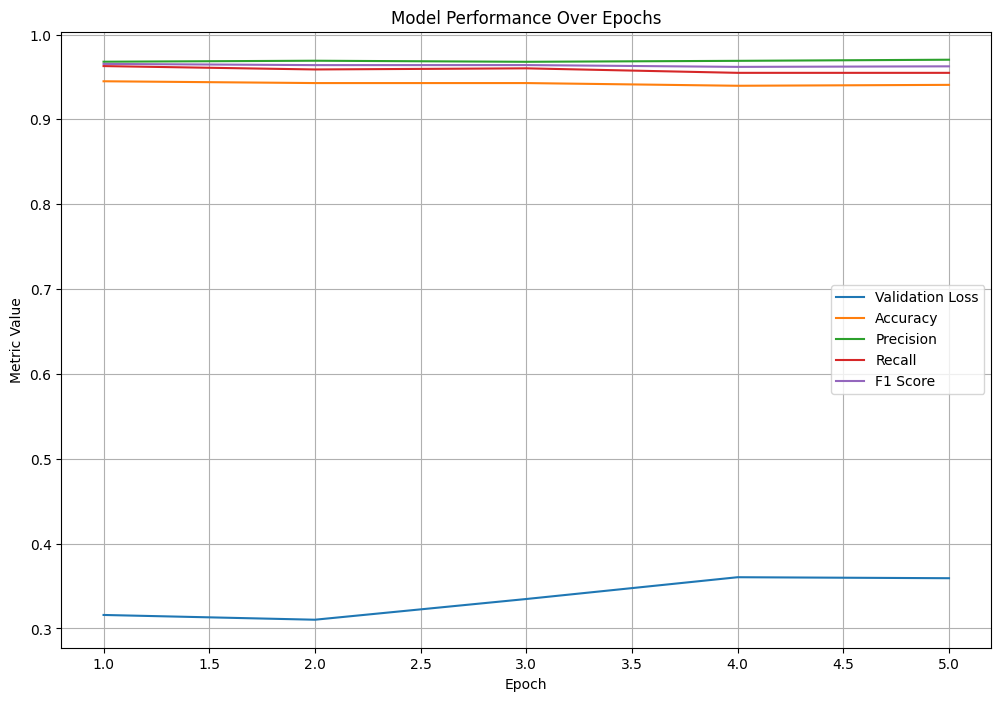

In [ ]:
# Plot all metrics after training
plt.figure(figsize=(12, 8))

plt.plot(epoch_numbers, val_losses, label="Validation Loss")
plt.plot(epoch_numbers, val_accuracies, label="Accuracy")
plt.plot(epoch_numbers, val_precisions, label="Precision")
plt.plot(epoch_numbers, val_recalls, label="Recall")
plt.plot(epoch_numbers, val_f1s, label="F1 Score")

plt.xlabel("Epoch")
plt.ylabel("Metric Value")
plt.title("Model Performance Over Epochs")
plt.legend()
plt.grid()
plt.show()

# As we can see from this graph, all scores of accuracy, precision, recall, and f1 score are already very high beginning from epoch 1. This is because the distilBERT model is already very good at simple sentiment classification tasks.



